In [1]:
#@title Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import matplotlib.pyplot as plt
import glob
import math
from pathlib import *
import re
import random
import copy
from tqdm.notebook import tqdm, trange
import gc
import datetime

In [2]:
#@title Free GPU Cache function
def free_gpu_cache():
# This function is used to clear the GPU cache and avoid memory problems when dealing with large populations and big models
    gc.collect()
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()


In [4]:
#@title Food Source class
class FoodSource:
# The food sources will hold the models and represent the position in the hyperspace where the algorithm's agents are
    def __init__(self, net, fs_exhaustion_limit, cycle_length, max_cycles, lr_bounds):
        self.food = net # The food source's food is the model to be improved
        self.fs_exhaustion_limit = fs_exhaustion_limit # Number of times a food source can be exploited before considering it exhausted (local minimum)
        self.cycle_length = cycle_length
        self.stepsize = self.cycle_length * len(train_loader) # According to L.N.Smith, sz = 2-10 times the epoch length
        self.lrs = np.concatenate([np.linspace(lr_bounds[0], lr_bounds[1], num = self.stepsize, endpoint = False), np.linspace(lr_bounds[1], lr_bounds[0], num = self.stepsize, endpoint = False)])
        self.t_epochs = max_cycles * cycle_length # Max epochs to be trained, unless the model starts overfitting
        self.optimizer = optim.Adam(self.food.parameters(), self.lrs[0])

        self.fs_exhaustion = 0
        self.nectar = 0
        self.nectar_ev = [0]
        self.train_loss_ev = [0]
        self.val_loss_ev = [0]

    def mutate_feature_extractor(self, mut_amount = 1, max_layers = np.inf, max_k_size = 5, c_p_ratio = 5, reset_prob = 0.7, operations = ["add", "mut", "del", "res"], op_weights = [15, 20, 5, 5]):
    # This function takes a model and mutates its layer as to obtain a distinct but similar one
        deprecated = True

        while deprecated:
            #mut_amount = int(abs(np.random.normal(loc=1.0, scale=(1+self.fs_exhaustion)**1/3))+1)
            try:
                for m in range(mut_amount):
                    model_mutated = copy.deepcopy(self.food)
                    mut_type = random.choices(operations, weights = op_weights)[0]
                    features = 0
                    if mut_type == "add" and len(model_mutated.features) < max_layers:
                        self.add_layer(model_mutated, max_k_size, c_p_ratio)
                        features = 1
                    elif mut_type == "mut":
                        self.mut_layer(model_mutated, max_k_size)
                        features = 1
                    elif mut_type == "del" and len(model_mutated.features) > 2:
                        self.del_layer(model_mutated)
                        features = 1
                    elif mut_type == "cav":
                        self.change_avg_pool(model_mutated)
                        features = 1
                    elif mut_type == "res":
                        self.reset_weights(model_mutated, reset_prob)
                        features = 1
                    elif mut_type == "clr":
                        self.change_lr()

                self.prune_model(model_mutated)

                output_size = [0, model_mutated.avgpool.output_size[0], model_mutated.avgpool.output_size[1]]
                index = len(model_mutated.features)
                while output_size[0] == 0 and index > 0:
                    index -= 1
                    if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
                        output_size[0] = model_mutated.features[index].out_channels

                for dim in output_size:
                    features = features*dim

                if features > 0:
                    deprecated = False
            except:
                deprecated = True

        model_mutated.classifier = nn.Sequential(torch.nn.modules.activation.ReLU(inplace = True),
                                                 nn.Linear(in_features=int(features), out_features=500, bias=True),
                                                 torch.nn.modules.activation.ReLU(inplace = True),
                                                 torch.nn.modules.dropout.Dropout(p = 0.5, inplace = False),
                                                 nn.Linear(in_features=500, out_features=10, bias=True),
                                                 nn.LogSoftmax(dim=1))
        self.food = copy.deepcopy(model_mutated)

    def prune_model(self, model_mutated, print_change = False):
    # This function makes sure that the model layers do not present incongruent patterns
        if print_change:
            print("Pruning model")
        
        index = 1
        condition = True
        while condition:
            if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
                cl = "conv"
            elif type(model_mutated.features[index]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index]) == torch.nn.modules.pooling.AvgPool2d:
                cl = "pool"
            elif type(model_mutated.features[index]) == torch.nn.modules.activation.ReLU or type(model_mutated.features[index]) == torch.nn.Tanh or type(model_mutated.features[index]) == torch.nn.Sigmoid:
                cl = "act_fun"
            if type(model_mutated.features[index-1]) == torch.nn.modules.conv.Conv2d:
                pl = "conv"
            elif type(model_mutated.features[index-1]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index-1]) == torch.nn.modules.pooling.AvgPool2d:
                pl = "pool"
            elif type(model_mutated.features[index-1]) == torch.nn.modules.activation.ReLU or type(model_mutated.features[index-1]) == torch.nn.Tanh or type(model_mutated.features[index-1]) == torch.nn.Sigmoid:
                pl = "act_fun"
            
            if pl == "conv" and cl == "conv": # We add a ReLU between two consecutive conv layers
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], torch.nn.modules.activation.ReLU(inplace = True), *list(model_mutated.features.children())[index:])
                index = 0
            elif pl == "act_fun" and cl == "pool": # If an act function precedes a pooling layer, they are switched 
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index-1], model_mutated.features[index], model_mutated.features[index-1], *list(model_mutated.features.children())[index+1:])
                index = 0
            elif pl == cl: # If two layers are the same (but not conv), the first one is removed
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index-1], *list(model_mutated.features.children())[index:])
                index = 0
            index += 1
            condition = index < len(model_mutated.features)
    
    def change_lr(self, print_change = False):
        new_lr_min = random.choice([1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6]) # Gotta make this an input
        new_lr_range = random.choice([5, 10, 20]) # Gotta make this an input
        self.lrs = np.concatenate([np.linspace(new_lr_min, new_lr_min*new_lr_range, num = self.stepsize, endpoint = False), np.linspace(new_lr_min*new_lr_range, new_lr_min, num = self.stepsize, endpoint = False)])
        if print_change:
            print("Learning rate updated.")
    
    def change_avg_pool(self, model_mutated , print_change = False):
        max_out_size = 50 # Gotta make this an input
        model_mutated.avgpool = nn.AdaptiveAvgPool2d([random.randint(1, max_out_size), random.randint(1, max_out_size)])
        
    def add_layer(self, model_mutated, max_k_size, c_p_ratio, print_change = False):
        cw = 0.01
        pw = 0.01
        #afw = 0.01
        for layer in model_mutated.features:
            if type(layer) == torch.nn.modules.conv.Conv2d:
                cw += 1
            elif type(layer) == torch.nn.modules.pooling.MaxPool2d or type(layer) == torch.nn.modules.pooling.AvgPool2d:
                pw += 1
            #elif type(layer) == torch.nn.ReLU() or type(layer) == torch.nn.Tanh() or type(layer) == torch.nn.Sigmoid():
                #afw += 1
        layer_type = random.choices(["conv", "pool"], weights = [c_p_ratio/cw, 1/pw], k = 1)[0] # , "act_fun", 1/afw
        index = random.randint(1, len(model_mutated.features))

        if print_change:
            print("Inserting", layer_type, "at layer", index)
        if layer_type == "pool":
            pool_type = random.choice(["max", "avg"])
            k_size = random.randint(2, max_k_size)
            st = random.randint(1, k_size)
            if pool_type == "max":
                new_layer = nn.MaxPool2d(kernel_size=k_size, stride=st, padding=0)
            elif pool_type == "avg":
                new_layer = nn.AvgPool2d(kernel_size=k_size, stride=st, padding=0)

        elif layer_type == "act_fun":
            new_layer = nn.ReLU()

        elif layer_type == "conv":
            dim = 0 # The inserted convolutional layer will have the same input feature maps as output ones as to fit within
            index_search = index
            while dim == 0:
                index_search -= 1
                if index_search < 0:
                    dim = 1
                    break
                if type(model_mutated.features[index_search]) == torch.nn.modules.conv.Conv2d:
                    dim = model_mutated.features[index_search].out_channels
            k_size = (random.randint(1, max_k_size), random.randint(1, max_k_size))
            st = (random.randint(1, k_size[0]), random.randint(1, k_size[1]))
            pad = (random.randint(0, int(k_size[0]/2)), random.randint(0, int(k_size[1]/2)))
            new_layer = nn.Conv2d(dim, dim, kernel_size=k_size, stride=st, padding=pad)

        model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], new_layer, *list(model_mutated.features.children())[index:])

    def mut_layer(self, model_mutated, max_k_size, print_change = False):
        f_size_variab = 2

        index = random.randint(0, len(model_mutated.features)-1)
        index_end = index+1
        if print_change:
            print("Mutating layer", index)

        if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
            dim_in = model_mutated.features[index].in_channels
            dim_out = max(1, random.randint(int(model_mutated.features[index].out_channels/f_size_variab), min(int(model_mutated.features[index].out_channels*f_size_variab), 512)))
            k_size = (random.randint(1, max_k_size), random.randint(1, max_k_size))
            st = (random.randint(1, k_size[0]), random.randint(1, k_size[1]))
            pad = (random.randint(0, int(k_size[0]/2)), random.randint(0, int(k_size[1]/2)))
            mut_layer = nn.Conv2d(dim_in, dim_out, kernel_size=k_size, stride=st, padding=pad)
            while index_end < len(model_mutated.features) and type(model_mutated.features[index_end]) != torch.nn.modules.conv.Conv2d:
                index_end += 1
            if index_end < len(model_mutated.features):
                fixed_layer = nn.Conv2d(dim_out, model_mutated.features[index_end].out_channels, kernel_size=model_mutated.features[index_end].kernel_size, stride=model_mutated.features[index_end].stride, padding=model_mutated.features[index_end].padding)
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index+1:index_end], fixed_layer, *list(model_mutated.features.children())[index_end+1:])
            else:
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index+1:])

        elif type(model_mutated.features[index]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index]) == torch.nn.modules.pooling.AvgPool2d:
            pool_type = random.choice(["max", "avg"])
            k_size = random.randint(2, max_k_size)
            st = random.randint(1, k_size)
            if pool_type == "max":
                mut_layer = nn.MaxPool2d(kernel_size=k_size, stride=st, padding=0)
            elif pool_type == "avg":
                mut_layer = nn.AvgPool2d(kernel_size=k_size, stride=st, padding=0)
            model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index_end:])

        elif type(model_mutated.features[index]) == torch.nn.modules.ReLU or type(model_mutated.features[index]) == torch.nn.modules.Tanh or type(model_mutated.features[index]) == torch.nn.modules.Sigmoid:
            mut_layer = nn.ReLU()
            model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index_end:])

    def del_layer(self, model_mutated, print_change = False):
        index = random.randint(0, len(model_mutated.features)-1)
        index_end = index+1
        if print_change:
            print("Deleting layer", index)

        if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
            dim_in = model_mutated.features[index].in_channels
            while index_end < len(model_mutated.features) and type(model_mutated.features[index_end]) != torch.nn.modules.conv.Conv2d:
                index_end += 1
            if index_end < len(model_mutated.features):
                fixed_layer = nn.Conv2d(dim_in, model_mutated.features[index_end].out_channels, kernel_size=model_mutated.features[index_end].kernel_size, stride=model_mutated.features[index_end].stride, padding=model_mutated.features[index_end].padding)
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], *list(model_mutated.features.children())[index+1:index_end], fixed_layer, *list(model_mutated.features.children())[index_end+1:])
            else:
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], *list(model_mutated.features.children())[index+1:])

        # If it is a pooling or activation function layer we get rid of it directly
        elif type(model_mutated.features[index]) == torch.nn.modules.ReLU or type(model_mutated.features[index]) == torch.nn.modules.Tanh or type(model_mutated.features[index]) == torch.nn.modules.Sigmoid or type(model_mutated.features[index]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index]) == torch.nn.modules.pooling.AvgPool2d:
            model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], *list(model_mutated.features.children())[index_end:])

    def reset_weights(self, model_mutated, reset_prob, print_change = False): # Reinitialize the predictor's weights
        reseted_layers = []
        for index in range(len(model_mutated.features)):
            if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d and random.random() < reset_prob:
                reseted_layers += [index]
                nn.init.xavier_uniform_(model_mutated.features[index].weight.data, gain=nn.init.calculate_gain('relu'))
        if print_change:
            print("Weights reseted on layers", reseted_layers)
    
    def train_fs(self, patience = 6):
    # This function is used to train the model for a certain number of epochs
        self.food.to(device)
        loss_tra = []
        loss_val = []
        nectar_ev = []
        overfit = 0
        lr_index = 0
        invalid = False
        best_loss = np.inf
        with tqdm(total=self.t_epochs, leave = False, desc='Training') as pbar1:
            for epoch in range(self.t_epochs): # loop over the dataset multiple times
                running_loss = 0.0
                with tqdm(total=len(train_loader), leave = False, desc='Epoch progress') as pbar2:
                    for i, data in enumerate(train_loader, 0):
                        if lr_index >= len(self.lrs)-1:
                            lr_index -= len(self.lrs)
                        lr_index += 1
                        #self.optimizer = optim.SGD(self.food.parameters(), self.lrs[lr_index], self.moms[lr_index])
                        self.optimizer = optim.Adam(self.food.parameters(), self.lrs[lr_index])
                        # get the inputs; data is a list of [inputs, labels]
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)
                        # zero the parameter gradients
                        self.optimizer.zero_grad()
                        # forward + backward + optimize
                        
                        try:
                            outputs = self.food(inputs).squeeze()
                        except:
                            invalid = True
                            pbar2.update(len(train_loader))
                            break
                        
                        loss = criterion(outputs, labels)
                        #print(loss)
                        loss.backward()
                        self.optimizer.step()
                        running_loss += loss.item()
                        #loss_tra += [loss.item()]
                        pbar2.update(1)
                        if bool(np.isnan(loss.cpu().detach())):
                            invalid = True
                            pbar2.update(len(train_loader))
                            break
                # We keep track of the losses and nectar evolutions
                if invalid:
                    pbar1.update(self.t_epochs)
                    break
                loss_tra += [running_loss/len(train_loader)]
                current_loss_val = self.validate_fs()
                loss_val += [current_loss_val]
                nectar_ev += [fitness_function(current_loss_val)]
                pbar1.update(1)
                if loss_val[-1] < best_loss:
                    best_loss = loss_val[-1]
                    overfit = 0
                    torch.save(self.food.state_dict(), "training_model.pt")
                else:
                    overfit += 1
                if overfit >= patience: # # If the loss does not decrease for a few epochs we assume overfitting
                    pbar1.update(self.t_epochs)
                    break
        if not invalid:
            self.nectar_ev = copy.deepcopy(nectar_ev)
            self.train_loss_ev = copy.deepcopy(loss_tra)
            self.val_loss_ev = copy.deepcopy(loss_val)
            self.nectar = copy.deepcopy(np.max(nectar_ev))
        self.food.load_state_dict(torch.load("training_model.pt"))
        self.food.to("cpu")
        
        # We get rid of everything we don't need
        del loss_tra, loss_val, nectar_ev, overfit, lr_index, pbar1, pbar2, running_loss, i, data, self.optimizer, inputs, labels
        free_gpu_cache()
        return invalid
        
    def validate_fs(self):
    # This function is used to test the accuracy of a given model on the validation dataset
        total_loss = 0
        total_iter = 0
        
        self.food.eval()
        with tqdm(total=len(val_loader), leave = False, desc = "Checking current performance") as pbar:
            with torch.no_grad():# since we're not training, we don't need to calculate the gradients for our outputs
                for data in val_loader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = self.food(images).squeeze()
                    loss = criterion(outputs, labels)
                    total_iter += 1
                    total_loss += loss.item()
                    pbar.update(1)
        del images, labels, data, loss
        self.food.train()
        return total_loss / total_iter

In [3]:
#@title Stats class
class Stats:
# This class holds all the variables of interest for the inspection of the evolution of both mean and best models
    def __init__(self):
        self.frames = []
        self.train_loss_evolution_best = []
        self.val_loss_evolution_best = []
        self.conv_layers_evolution_best = []
        self.avg_pool_layers_evolution_best = []
        self.max_pool_layers_evolution_best = []
        self.mean_conv_kernel_width_evolution_best = []
        self.mean_conv_kernel_heigth_evolution_best = []
        self.mean_pool_kernel_size_evolution_best = []
        self.mean_conv_stride_width_evolution_best = []
        self.mean_conv_stride_heigth_evolution_best = []
        self.mean_pool_stride_size_evolution_best = []
        self.mean_num_features_evolution_best = []
        self.num_parameters_evolution_best = []
        
        self.train_loss_evolution_mean = []
        self.val_loss_evolution_mean = []
        self.conv_layers_evolution_mean = []
        self.avg_pool_layers_evolution_mean = []
        self.max_pool_layers_evolution_mean = []
        self.mean_conv_kernel_width_evolution_mean = []
        self.mean_conv_kernel_heigth_evolution_mean = []
        self.mean_pool_kernel_size_evolution_mean = []
        self.mean_conv_stride_width_evolution_mean = []
        self.mean_conv_stride_heigth_evolution_mean = []
        self.mean_pool_stride_size_evolution_mean = []
        self.mean_num_features_evolution_mean = []
        self.num_parameters_evolution_mean = []
        
    def update(self, bees, ex_ffss):
        best_loss = 10000
        total_loss = 0
        total_conv_layers = 0
        total_avg_layers = 0
        total_max_layers = 0
        total_num_param = 0
        total_conv_kernel_width = 0
        total_conv_kernel_height = 0
        total_pool_kernel_size = 0
        total_conv_stride_width = 0
        total_conv_stride_height = 0
        total_pool_stride_size = 0
        total_num_features = 0
        total_val_loss = 0
        total_train_loss = 0
        for fs in [bee.fs for bee in bees[0:Np]] + ex_ffss:
            if np.mean(fs.val_loss_ev[-4:]) < best_loss:
                best_loss = copy.deepcopy(np.mean(fs.val_loss_ev[-4:]))
                best_fs = copy.deepcopy(fs)
                self.best_model = copy.deepcopy(best_fs.food)
            
            for l in list(fs.food.features.children()):
                conv_layers = 0
                avg_pool_layers = 0
                avg_pool_layers = 0
                conv_kernel_width = 0
                conv_kernel_height = 0
                conv_stride_width = 0
                conv_stride_height = 0
                num_features = 0
                max_pool_layers = 0
                pool_kernel_size = 0
                pool_stride_size = 0
                if type(l) == torch.nn.modules.conv.Conv2d:
                    conv_layers += 1
                    conv_kernel_width += l.kernel_size[1]
                    conv_kernel_height += l.kernel_size[0]
                    conv_stride_width += l.stride[1]
                    conv_stride_height += l.stride[0]
                    num_features += l.out_channels
                
                elif type(l) == torch.nn.modules.pooling.MaxPool2d:
                    max_pool_layers += 1
                    pool_kernel_size += l.kernel_size
                    pool_stride_size += l.stride
                elif type(l) == torch.nn.modules.pooling.AvgPool2d:
                    avg_pool_layers += 1
                    pool_kernel_size += l.kernel_size
                    pool_stride_size += l.stride
            
                total_conv_layers += conv_layers
                total_avg_layers += avg_pool_layers
                total_max_layers += max_pool_layers
                
            if conv_layers == 0:
                total_conv_kernel_width += 0
                total_conv_kernel_height += 0
                total_conv_stride_width += 0
                total_conv_stride_height += 0
                total_num_features += 0
            else:
                total_conv_kernel_width += conv_kernel_width/conv_layers
                total_conv_kernel_height += conv_kernel_height/conv_layers
                total_conv_stride_width += conv_stride_width/conv_layers
                total_conv_stride_height += conv_stride_height/conv_layers
                total_num_features += num_features/conv_layers
            if max_pool_layers + avg_pool_layers == 0:
                total_pool_kernel_size += 0
                total_pool_stride_size += 0
            else:
                total_pool_kernel_size += pool_kernel_size/(max_pool_layers + avg_pool_layers)
                total_pool_stride_size += pool_stride_size/(max_pool_layers + avg_pool_layers)
                
            total_val_loss += copy.deepcopy(np.mean(fs.val_loss_ev[-4:]))
            total_train_loss += copy.deepcopy(np.mean(fs.train_loss_ev[-4:]))
            total_num_param += sum (p.numel () for p in fs.food.parameters ())

        self.train_loss_evolution_mean += [total_train_loss/(Np+len(ex_ffss))]
        self.val_loss_evolution_mean += [total_val_loss/(Np+len(ex_ffss))]
        self.conv_layers_evolution_mean += [total_conv_layers/(Np+len(ex_ffss))]
        self.avg_pool_layers_evolution_mean += [total_avg_layers/(Np+len(ex_ffss))]
        self.max_pool_layers_evolution_mean += [total_max_layers/(Np+len(ex_ffss))]
        self.mean_conv_kernel_width_evolution_mean += [total_conv_kernel_width/(Np+len(ex_ffss))]
        self.mean_conv_kernel_heigth_evolution_mean += [total_conv_kernel_height/(Np+len(ex_ffss))]
        self.mean_pool_kernel_size_evolution_mean += [total_pool_kernel_size/(Np+len(ex_ffss))]
        self.mean_conv_stride_width_evolution_mean += [total_conv_stride_width/(Np+len(ex_ffss))]
        self.mean_conv_stride_heigth_evolution_mean += [total_conv_stride_height/(Np+len(ex_ffss))]
        self.mean_pool_stride_size_evolution_mean += [total_pool_stride_size/(Np+len(ex_ffss))]
        self.mean_num_features_evolution_mean += [total_num_features/(Np+len(ex_ffss))]
        self.num_parameters_evolution_mean += [total_num_param/(Np+len(ex_ffss))]
        
        conv_layers = 0
        avg_pool_layers = 0
        avg_pool_layers = 0
        conv_kernel_width = 0
        conv_kernel_height = 0
        conv_stride_width = 0
        conv_stride_height = 0
        num_features = 0
        max_pool_layers = 0
        pool_kernel_size = 0
        pool_stride_size = 0
        for l in list(best_fs.food.features.children()):
            if type(l) == torch.nn.modules.conv.Conv2d:
                conv_layers += 1
                conv_kernel_width += l.kernel_size[1]
                conv_kernel_height += l.kernel_size[0]
                conv_stride_width += l.stride[1]
                conv_stride_height += l.stride[0]
                num_features += l.out_channels

            elif type(l) == torch.nn.modules.pooling.MaxPool2d:
                max_pool_layers += 1
                pool_kernel_size += l.kernel_size
                pool_stride_size += l.stride
            elif type(l) == torch.nn.modules.pooling.AvgPool2d:
                avg_pool_layers += 1
                pool_kernel_size += l.kernel_size
                pool_stride_size += l.stride
        
        self.train_loss_evolution_best += [copy.deepcopy(np.mean(best_fs.train_loss_ev[-4:]))]
        self.val_loss_evolution_best += [copy.deepcopy(np.mean(best_fs.val_loss_ev[-4:]))]
        self.conv_layers_evolution_best += [conv_layers]
        self.avg_pool_layers_evolution_best += [avg_pool_layers]
        self.max_pool_layers_evolution_best += [max_pool_layers]
        if conv_layers == 0:
            self.mean_conv_kernel_width_evolution_best += [0]
            self.mean_conv_kernel_heigth_evolution_best += [0]
            self.mean_conv_stride_width_evolution_best += [0]
            self.mean_conv_stride_heigth_evolution_best += [0]
            self.mean_num_features_evolution_best += [0]
        else:
            self.mean_conv_kernel_width_evolution_best += [conv_kernel_width/conv_layers]
            self.mean_conv_kernel_heigth_evolution_best += [conv_kernel_height/conv_layers]
            self.mean_conv_stride_width_evolution_best += [conv_stride_width/conv_layers]
            self.mean_conv_stride_heigth_evolution_best += [conv_stride_height/conv_layers]
            self.mean_num_features_evolution_best += [num_features/conv_layers]
        if max_pool_layers + avg_pool_layers == 0:
            self.mean_pool_kernel_size_evolution_best += [0]
            self.mean_pool_stride_size_evolution_best += [0]
        else:
            self.mean_pool_kernel_size_evolution_best += [pool_kernel_size/(max_pool_layers + avg_pool_layers)]
            self.mean_pool_stride_size_evolution_best += [pool_stride_size/(max_pool_layers + avg_pool_layers)]
        self.num_parameters_evolution_best += [sum (p.numel () for p in best_fs.food.parameters ())]
    
    def show_stats(self):
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_evolution_best)
        plt.plot(self.val_loss_evolution_best)
        plt.legend(["Training loss", "Validation loss"])
        plt.title("Best model's loss evolution")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.train_loss_evolution_mean)
        plt.plot(self.val_loss_evolution_mean)
        plt.legend(["Training loss", "Validation loss"])
        plt.title("Mean model's loss evolution")
        plt.show()
        
        plt.subplot(1, 2, 1)
        plt.plot(self.conv_layers_evolution_best)
        plt.plot(self.avg_pool_layers_evolution_best)
        plt.plot(self.max_pool_layers_evolution_best)
        plt.legend(["Convolutional layers", "Avg pool layers", "Max pool layers"])
        plt.title("Best model's number of layers")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.conv_layers_evolution_mean)
        plt.plot(self.avg_pool_layers_evolution_mean)
        plt.plot(self.max_pool_layers_evolution_mean)
        plt.legend(["Convolutional layers", "Avg pool layers", "Max pool layers"])
        plt.title("Mean model's number of layers")
        plt.show()
        
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_conv_kernel_width_evolution_best)
        plt.plot(self.mean_conv_kernel_heigth_evolution_best)
        plt.plot(self.mean_pool_kernel_size_evolution_best)
        plt.legend(["Conv mean kernel width", "Conv mean kernel height", "Pool mean kernel size"])
        plt.title("Best model's mean kernel sizes")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.mean_conv_kernel_width_evolution_mean)
        plt.plot(self.mean_conv_kernel_heigth_evolution_mean)
        plt.plot(self.mean_pool_kernel_size_evolution_mean)
        plt.legend(["Conv mean kernel width", "Conv mean kernel height", "Pool mean kernel size"])
        plt.title("Mean model's mean kernel sizes")
        plt.show()
        
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_conv_stride_width_evolution_best)
        plt.plot(self.mean_conv_stride_heigth_evolution_best)
        plt.plot(self.mean_pool_stride_size_evolution_best)
        plt.legend(["Conv mean stride width", "Conv mean stride height", "Pool mean stride size"])
        plt.title("Best model's mean stride sizes")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.mean_conv_stride_width_evolution_mean)
        plt.plot(self.mean_conv_stride_heigth_evolution_mean)
        plt.plot(self.mean_pool_stride_size_evolution_mean)
        plt.legend(["Conv mean stride width", "Conv mean stride height", "Pool mean stride size"])
        plt.title("Mean model's mean stride sizes")
        plt.show()
        
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_num_features_evolution_best)
        plt.plot(self.mean_num_features_evolution_mean)
        plt.legend(["Best model", "Mean model"])
        plt.title("Mean number of feature maps")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.num_parameters_evolution_best)
        plt.plot(self.num_parameters_evolution_mean)
        plt.legend(["Best model", "Mean model"])
        plt.title("Number of parameters")
        plt.show()


In [5]:
#@title Bee classes and Nectar function
class EmployedBee:
# Each Employed Bee has an associated food source and will only exploit that one
    def __init__(self, fs, bee_number):
        self.fs = fs
        self.b_type = "employed"
        self.scouting = False
        self.bee_number = bee_number

    def exploit_food_source(self):
        new_fs = copy.deepcopy(self.fs)

        try:
            new_fs.mutate_feature_extractor(int(abs(np.random.normal(loc=1.0, scale=(1+new_fs.fs_exhaustion)**1/3))+1)) # The bee looks for a food source nearby
            invalid = new_fs.train_fs() # and evaluates if it produces better nectar than the original one
            
            plt.subplot(Np, 2, 2*self.bee_number+1) # We plot both for comparisson
            plt.plot(new_fs.train_loss_ev)
            plt.plot(new_fs.val_loss_ev)

            if new_fs.nectar > self.fs.nectar: # If it is indeed better, the bee will change food source
                self.fs = copy.deepcopy(new_fs)
                self.fs.fs_exhaustion = 0
                return 1
            else: # If not, the bee will forget about the new food source and add 1 to the exhaustion counter
                self.fs.fs_exhaustion += 1
                if self.fs.fs_exhaustion >= self.fs.fs_exhaustion_limit: # If the food source doesn't have any better ones nearby, it is considered a local minima
                    self.scouting = True
                return 0
        except:
            return 0

class OnlookerBee:
# Onlooker bees will look at all current food sources and exploit the ones that look more promising
    def __init__(self, bee_number):
        self.b_type = "onlooker"
        self.bee_number = bee_number

    def scout_food_source(self, b_ffss, b_nectars):
        chosen_fs = True
        while chosen_fs: # If the random number generated does not match the probability of
            if random.random() > b_nectars[0]/sum(b_nectars): # the current food source being chosen,
                b_ffss = b_ffss[1:] + [b_ffss[0]] # we send that food source to the back of the list
                b_nectars = b_nectars[1:] + [b_nectars[0]]
            else:
                b_ffss = b_ffss[1:] + [b_ffss[0]]
                b_nectars = b_nectars[1:] + [b_nectars[0]]
                chosen_fs = False
        new_fs = copy.deepcopy(b_ffss[-1]) # If it does, we exploit it following the same procedure as for Employed Bees

        try:
            new_fs.mutate_feature_extractor(int(abs(np.random.normal(loc=1.0, scale=(1+new_fs.fs_exhaustion)**1/3))+1)) # The bee looks for a food source nearby
            invalid = new_fs.train_fs() # and evaluates if it produces better nectar than the original one
            
            plt.subplot(Np, 2, 2*self.bee_number+2)
            plt.plot(new_fs.train_loss_ev)
            plt.plot(new_fs.val_loss_ev)

            if new_fs.nectar > b_ffss[0].nectar:
                b_ffss[0] = copy.deepcopy(new_fs)
                b_ffss[0].fs_exhaustion = 0
                return 1, b_ffss, b_nectars
            else:
                b_ffss[0].fs_exhaustion += 1
                return 0, b_ffss, b_nectars
        except:
            return 0, b_ffss, b_nectars

def fitness_function(score):
# This is the fitness function to retrieve the nectar amount as defined for the ABC algorithm
    if score >= 0:
        fitness = 1 / (1 + score)
    else:
        fitness = 1 + abs(score)
    return fitness

In [6]:
#@title Beehive class (gotta define the model outside the class and call it)
class Beehive:
    def __init__(self, Np = 5, model_name = "[custom net]", fs_exhaustion_limit = 15, cycle_length = 8, max_cycles = 8, lr_bounds = [5e-6, 5e-5]):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("GPU available:", device == torch.device('cuda'))

        self.bees = []
        self.ex_ffss = []
        self.ffss = []
        self.Np = Np
        free_gpu_cache()

        model = torch.hub.load('pytorch/vision:v0.10.0', "vgg11", pretrained=True)

        model.features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        model.avgpool = nn.AdaptiveAvgPool2d([10, 10])

        output_size = [0, model.avgpool.output_size[0], model.avgpool.output_size[1]]
        index = len(model.features)
        while output_size[0] == 0:
            index -= 1
            if type(model.features[index]) == torch.nn.modules.conv.Conv2d:
                output_size[0] = model.features[index].out_channels

        features = 1
        for dim in output_size:
            features = features*dim

        model.classifier = nn.Sequential(nn.Linear(in_features=int(features), out_features=500, bias=True),
                                                torch.nn.modules.activation.ReLU(inplace = True),
                                                torch.nn.modules.dropout.Dropout(p = 0.5, inplace = False),
                                                nn.Linear(in_features=500, out_features=10, bias=True), 
                                                nn.LogSoftmax(dim=1))

        self.original_fs = FoodSource(net = model, fs_exhaustion_limit = fs_exhaustion_limit, cycle_length = cycle_length, max_cycles = max_cycles, lr_bounds = lr_bounds)
        self.original_fs.train_fs()

        with tqdm(total=self.Np, leave = False, desc = "Initializing population") as pbar:
            for b in range(self.Np):
                invalid = True
                while invalid:
                    base_fs = copy.deepcopy(self.original_fs)
                    base_fs.mutate_feature_extractor(15)
                    invalid = base_fs.train_fs()
                self.bees += [EmployedBee(copy.deepcopy(base_fs), b)]
                pbar.update(1)
        for b in range(self.Np):
            self.bees += [OnlookerBee(b)]

        self.current_iter = 0

        self.stats = Stats()
        self.stats.update(self.bees, self.ex_ffss)
    
    def find_foodsource(self, perf_thresh = 0, max_iter = 30):
        while self.current_iter < max_iter:
            self.current_iter += 1
            if self.stats.val_loss_evolution_best[-1] <= perf_thresh:
                print("Good food source found in", self.current_iter, "iterations")
                break
            print("")
            print("Iteration", self.current_iter, "of the algorithm")
            nectars = []
                
            #print("Employed Bee Phase")
            b = 0
            c = 0
            self.ffss = []
            with tqdm(total=self.Np, leave = False, desc = "Employed bee phase") as pbar:
                for bee in self.bees:    # Employed bee phase
                    if bee.b_type == "employed":
                        b += 1
                        c += bee.exploit_food_source()
                        pbar.update(1)
                        if bee.fs.fs_exhaustion >= bee.fs.fs_exhaustion_limit:
                            bee.scouting = True
                        self.ffss += [bee.fs]
                        nectars += [bee.fs.nectar]
            print(c, "better food sources found during employed bee phase")
            
            #print("Onlooking Bee Phase")
            b = 0
            c = 0
            with tqdm(total=self.Np, leave = False, desc = "Onlooker bee phase") as pbar:
                for bee in self.bees:  # Scouting bee phase
                    if bee.b_type == "onlooker":
                        b += 1
                        a, self.ffss, nectars= bee.scout_food_source(self.ffss, nectars)
                        c += a
                        pbar.update(1)
            print(c, "better food sources found during onlooker bee phase")
            
            #print("Scouting Bee Phase")
            a = 0
            b = 0
            with tqdm(total=self.Np, leave = False, desc = "Scouting bee phase") as pbar:
                for bee in self.bees:    # Scouting bee phase
                    if bee.b_type == "employed":
                        bee.fs = self.ffss[a]
                        a += 1
                        pbar.update(1)
                        if bee.scouting:
                            b += 1
                            self.ex_ffss += [copy.deepcopy(bee.fs)]
                            invalid = True
                            while invalid:
                                base_fs = copy.deepcopy(self.original_fs)
                                base_fs.mutate_feature_extractor(15)
                                invalid = base_fs.train_fs()
                            bee.fs = copy.deepcopy(base_fs)
                            bee.scouting = False
            if b == 0:
                print("No bees in scouting mode")
            else:
                print(c, "bees entered scouting mode")
            
            # We then print the algorithm's current results
            plt.show()
            self.stats.update(self.bees, self.ex_ffss)
            self.stats.show_stats()

        if self.current_iter == max_iter:
            print("Algorithm unable to find suitable food source in", self.current_iter, "iterations.")
    
        free_gpu_cache()

    def save_models(self, folder = "saved_models\\", directory = os.getcwd()):
        os.chdir(directory)
        run_id = str(datetime.datetime.today())
        for i in range(len(run_id)):
            if run_id[i] == "-" or run_id[i] == " " or run_id[i] == ":":
                run_id = run_id[:i]+"_"+run_id[i+1:]
            elif run_id[i] == ".":
                run_id = run_id[:i]
                break
        model_save_path = folder+run_id
        if not os.path.exists(model_save_path):
          os.makedirs(model_save_path)

        models = [bee.fs for bee in self.bees[:self.Np]] + self.ex_ffss
        for i in range(len(models)):
            model = copy.deepcopy(models[i])
            torch.save(model.food, model_save_path+"\\"+str(np.mean(model.val_loss_ev[-4:]))+".pt")

        del model, models

GPU available: True


Using cache found in C:\Users\agomez/.cache\torch\hub\pytorch_vision_v0.10.0


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Initializing population:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]


Iteration 1 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

4 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

3 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


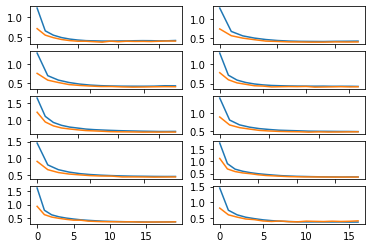

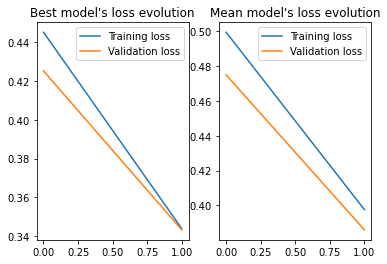

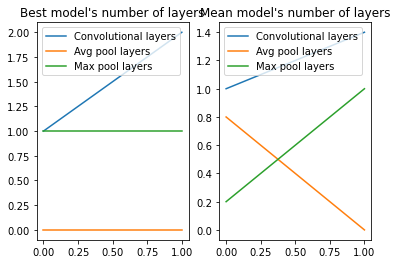

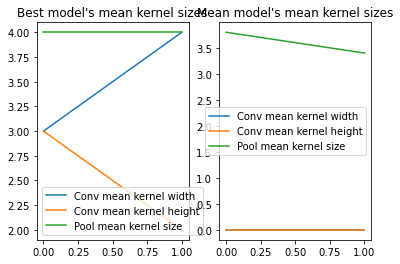

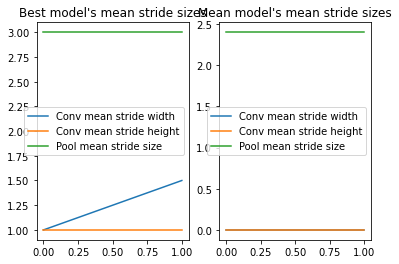

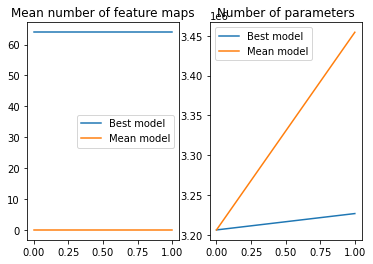


Iteration 2 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


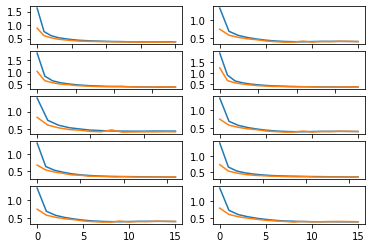

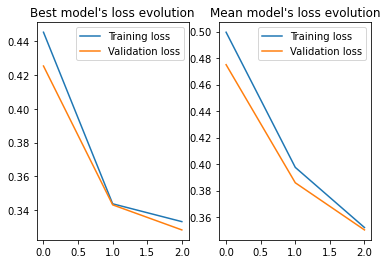

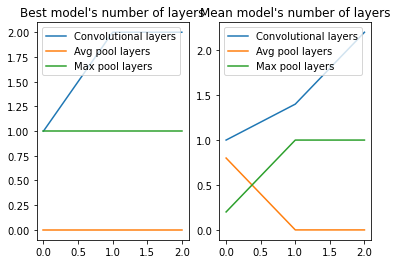

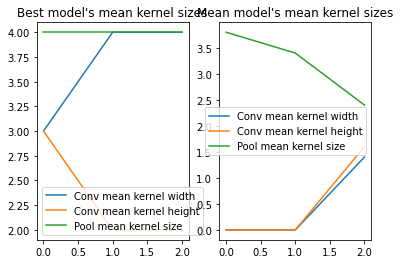

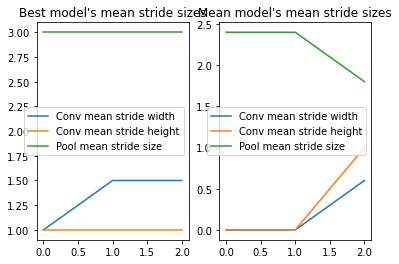

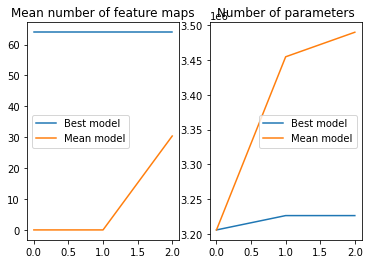


Iteration 3 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


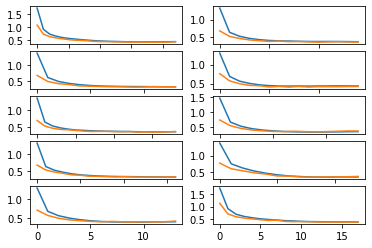

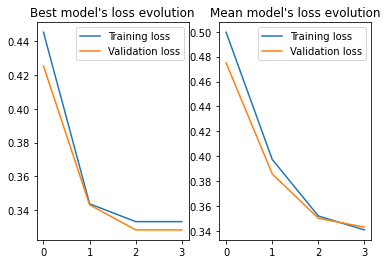

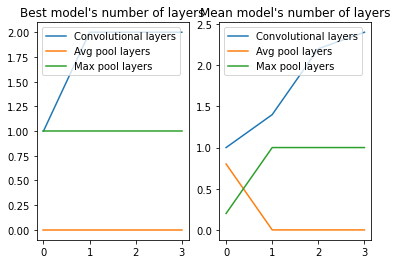

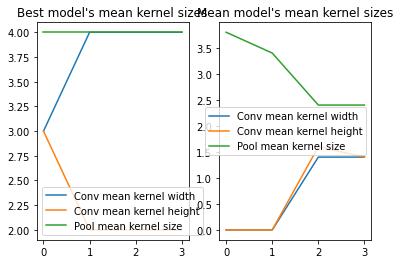

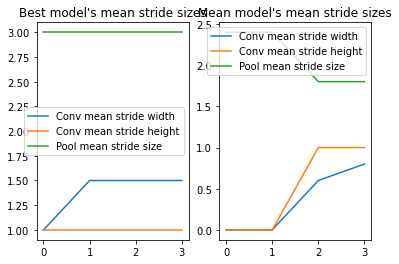

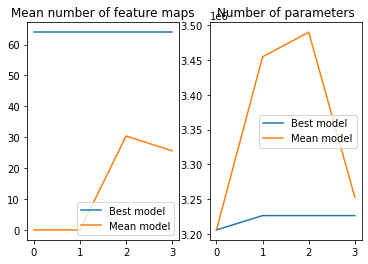


Iteration 4 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


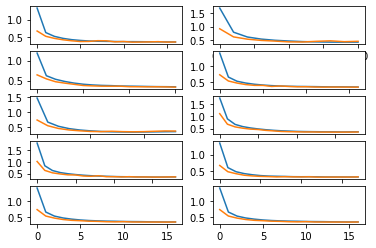

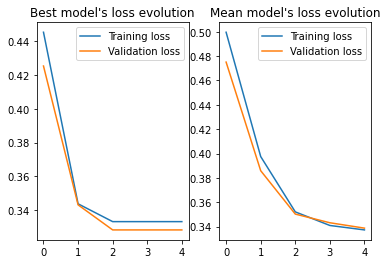

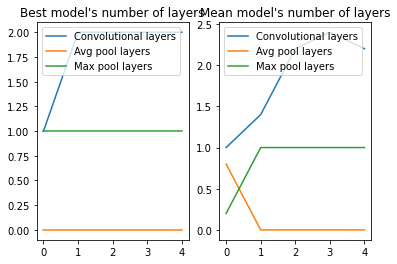

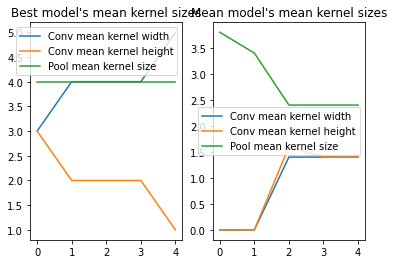

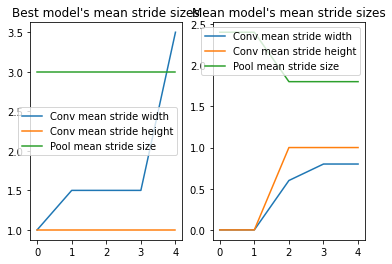

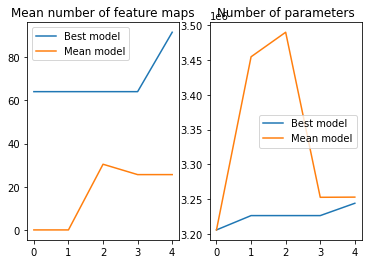


Iteration 5 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


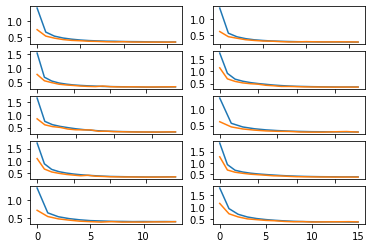

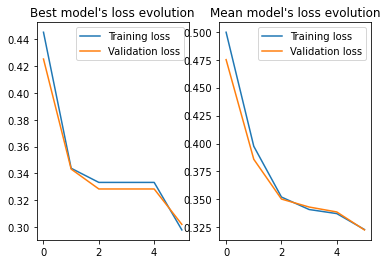

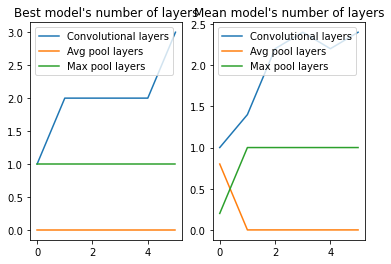

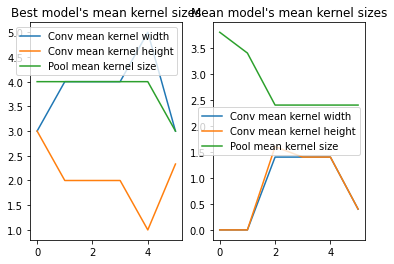

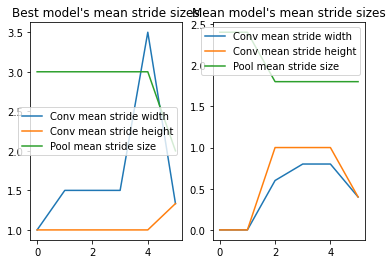

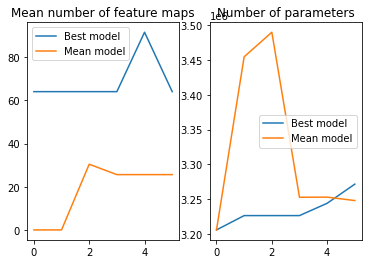


Iteration 6 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


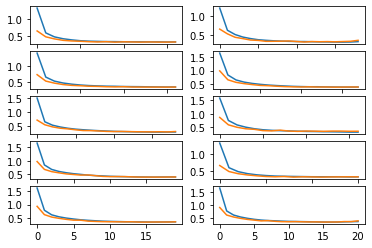

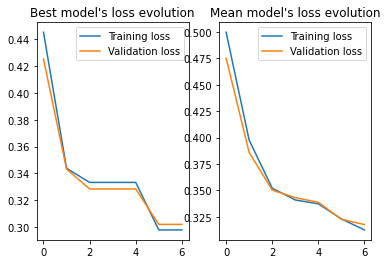

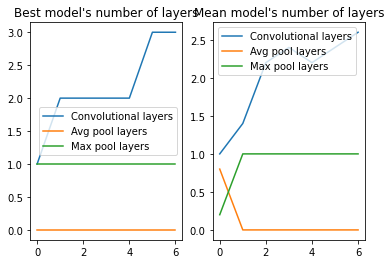

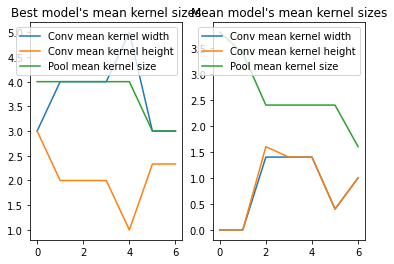

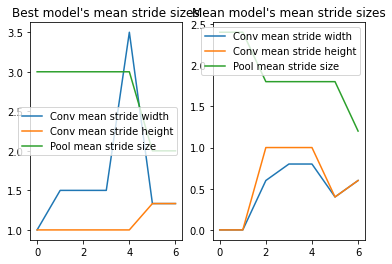

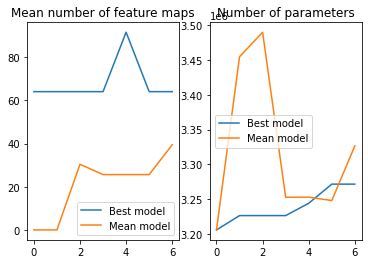


Iteration 7 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


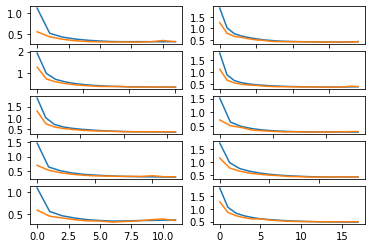

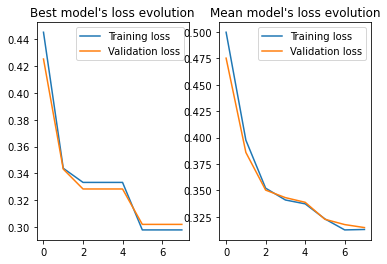

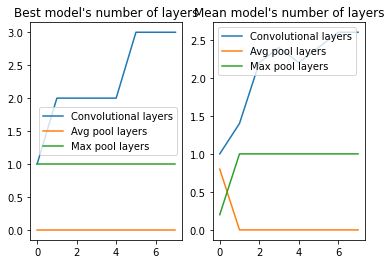

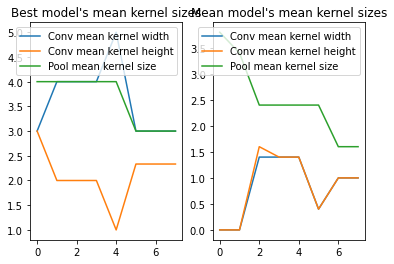

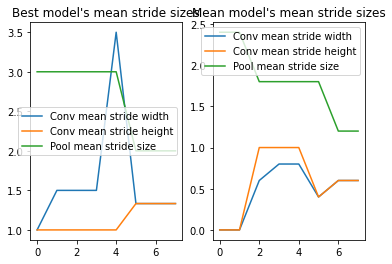

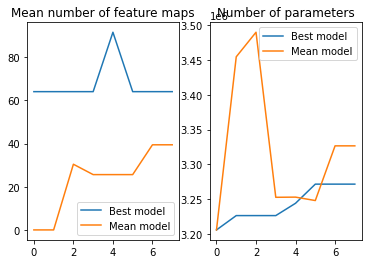


Iteration 8 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


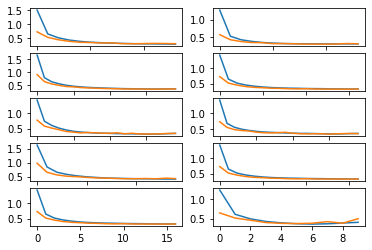

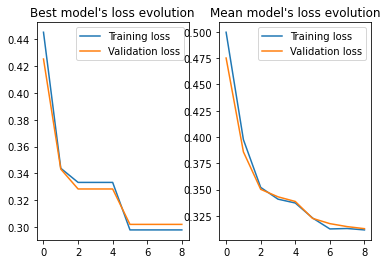

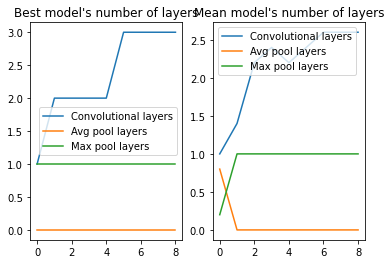

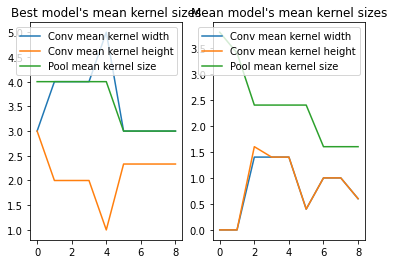

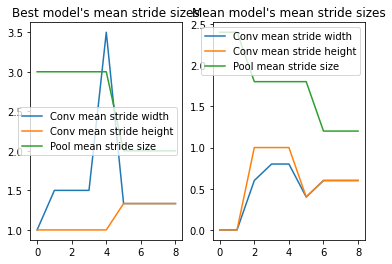

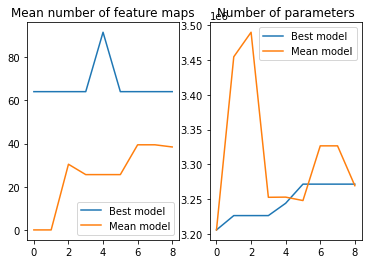


Iteration 9 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


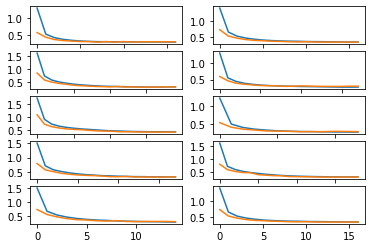

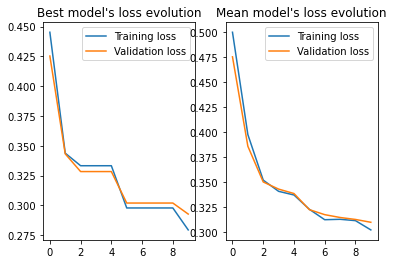

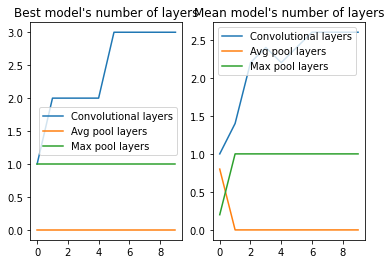

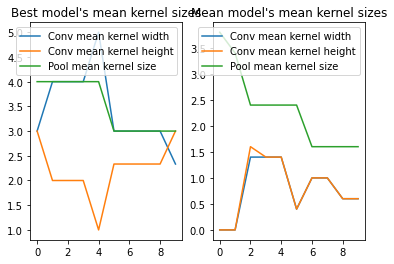

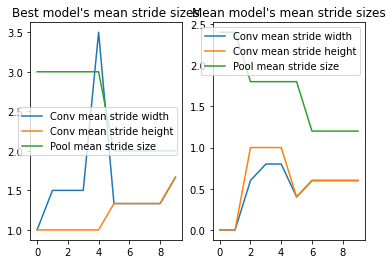

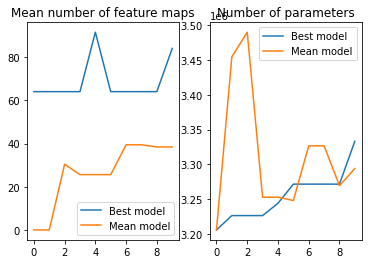


Iteration 10 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


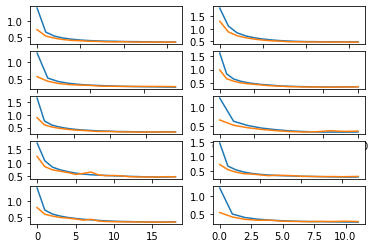

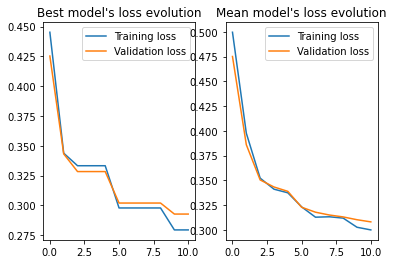

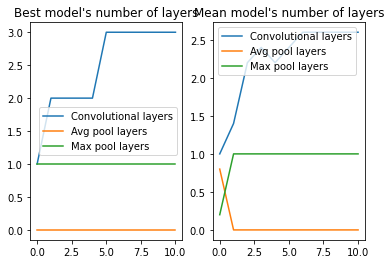

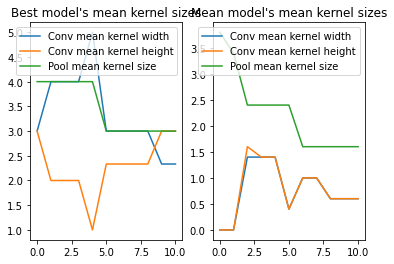

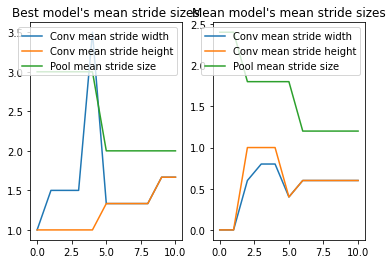

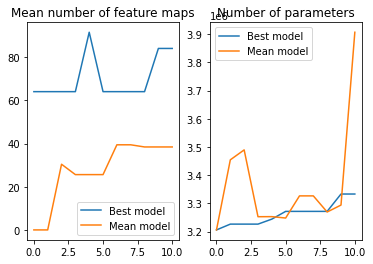


Iteration 11 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


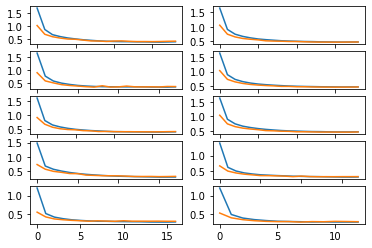

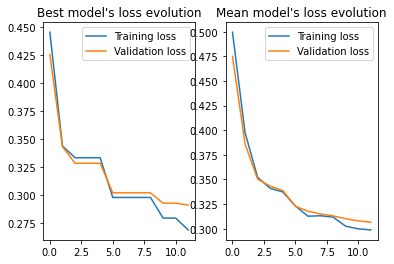

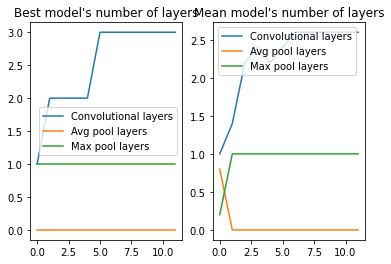

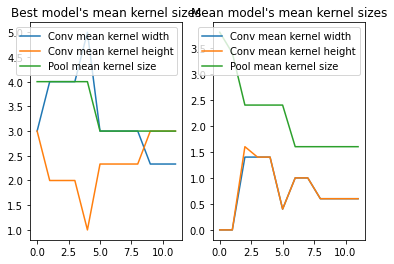

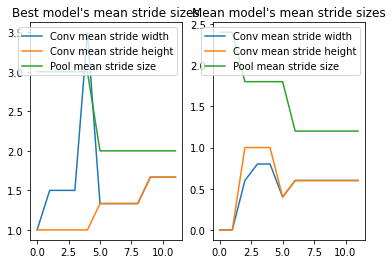

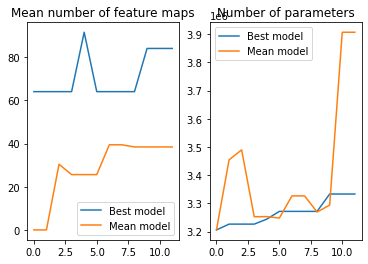


Iteration 12 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


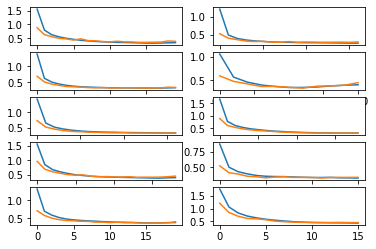

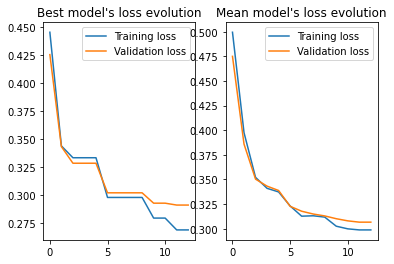

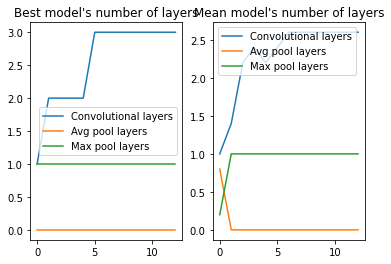

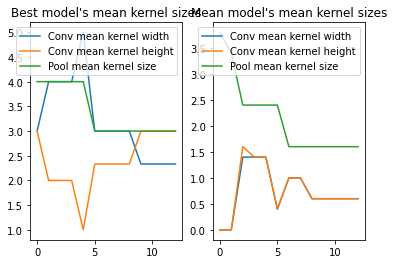

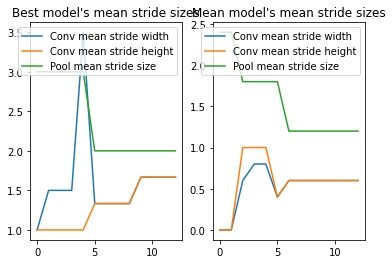

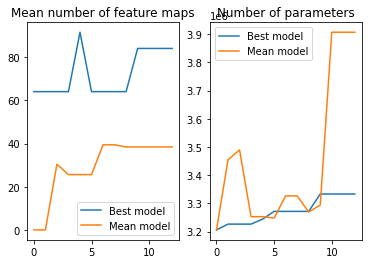


Iteration 13 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

2 bees entered scouting mode


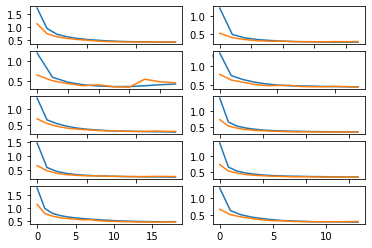

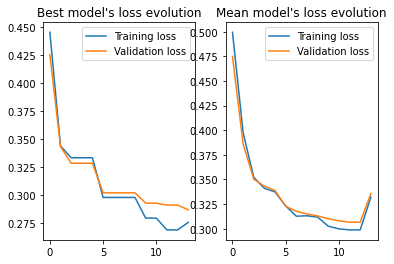

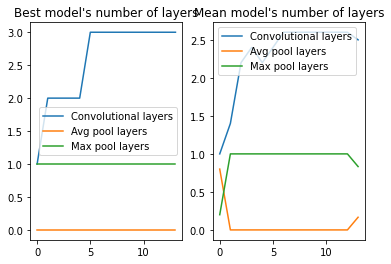

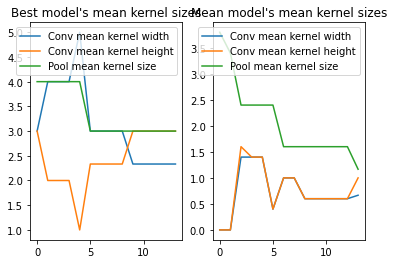

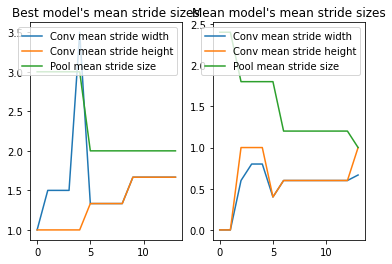

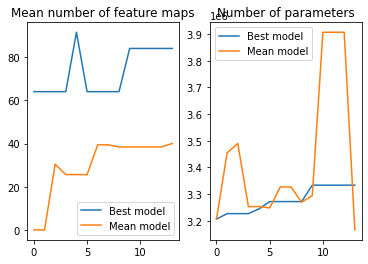


Iteration 14 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 bees entered scouting mode


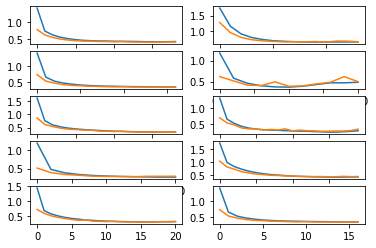

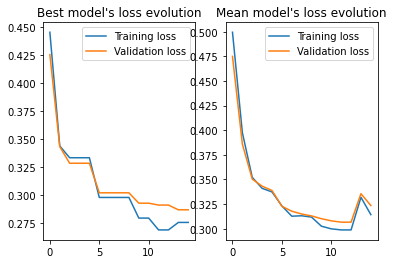

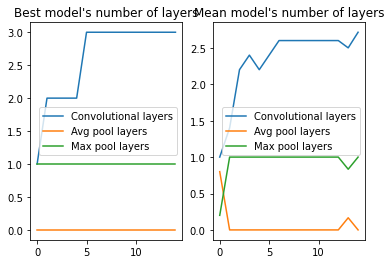

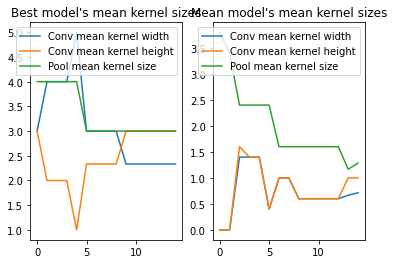

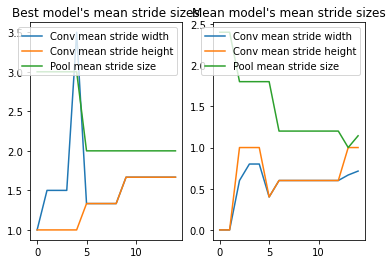

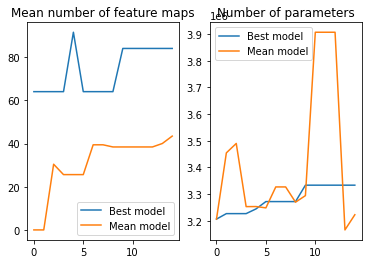


Iteration 15 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

3 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

3 bees entered scouting mode


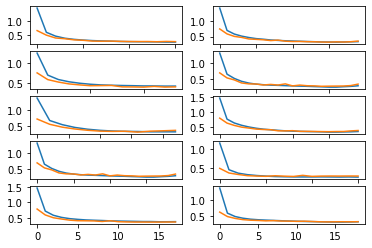

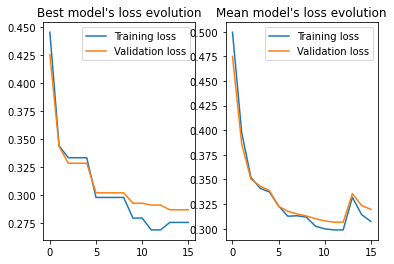

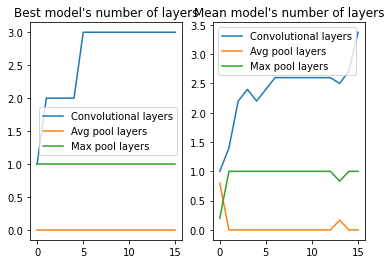

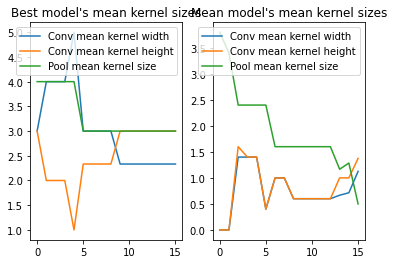

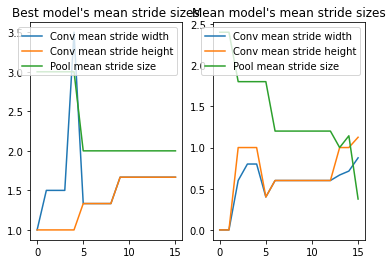

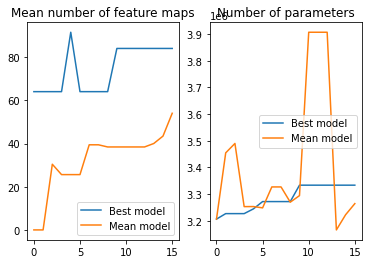


Iteration 16 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


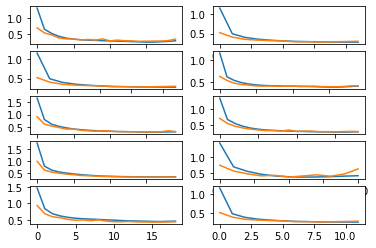

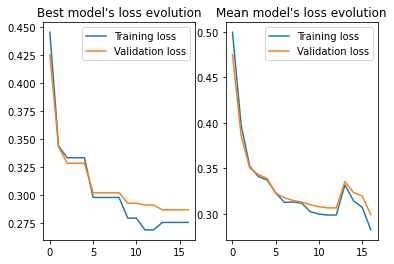

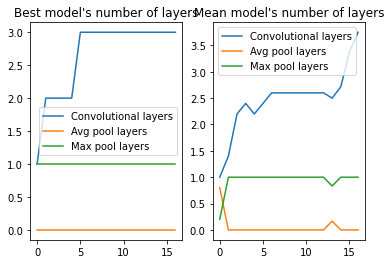

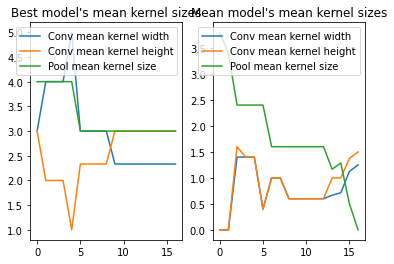

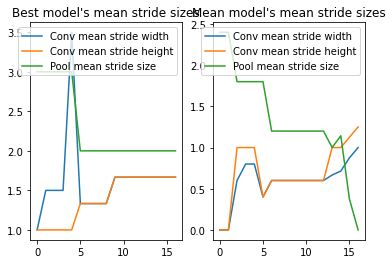

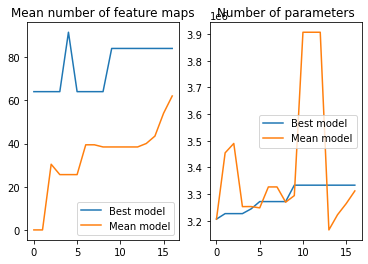


Iteration 17 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


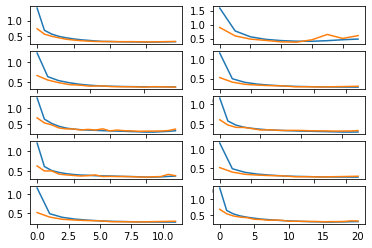

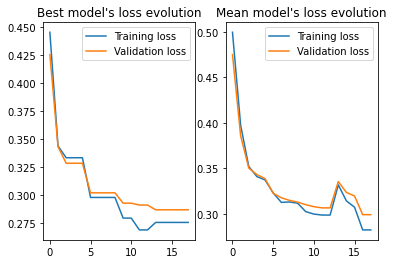

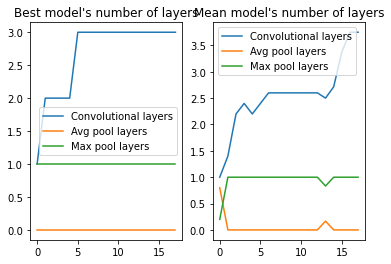

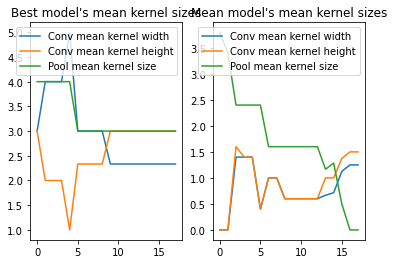

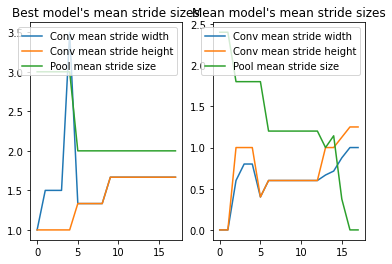

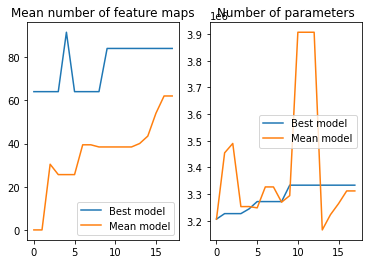


Iteration 18 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


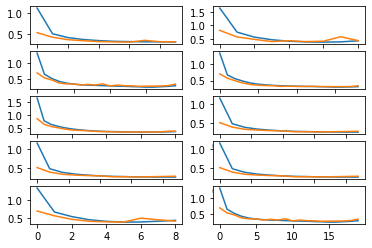

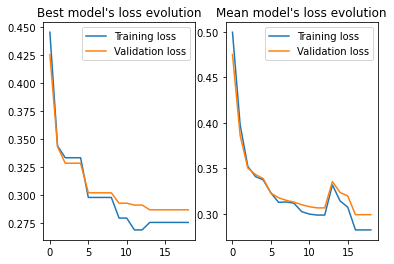

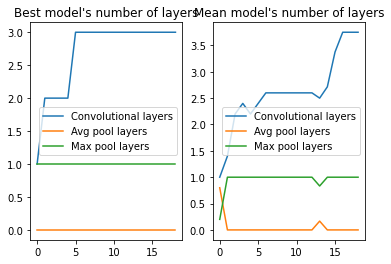

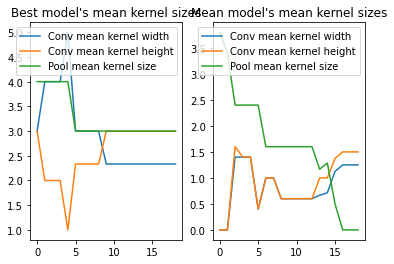

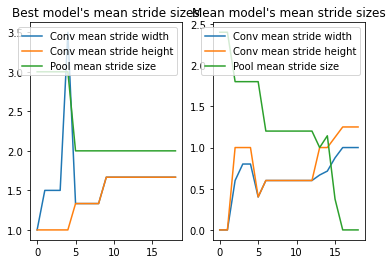

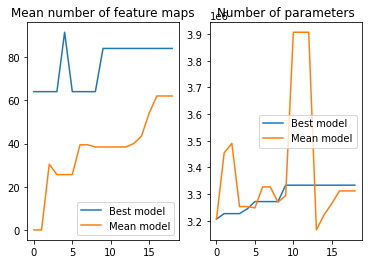


Iteration 19 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


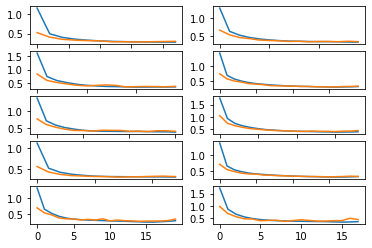

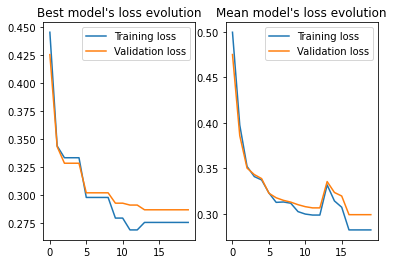

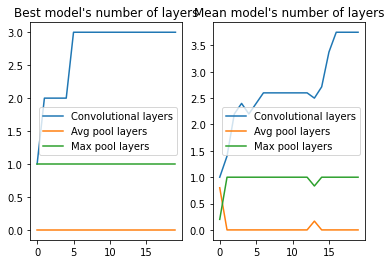

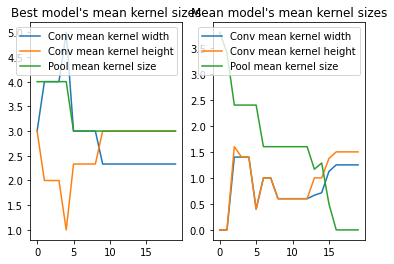

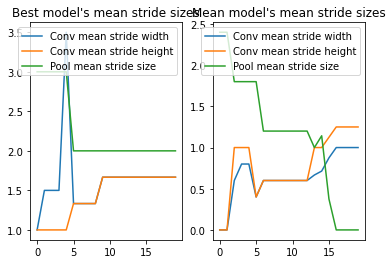

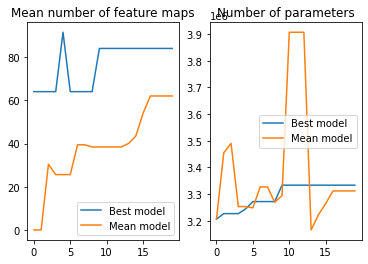


Iteration 20 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


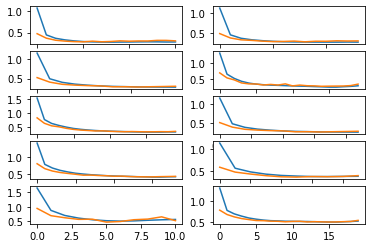

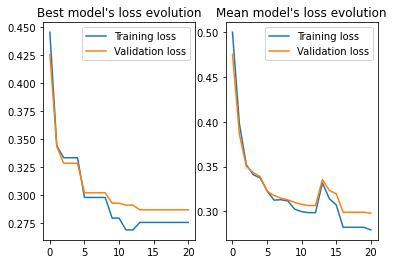

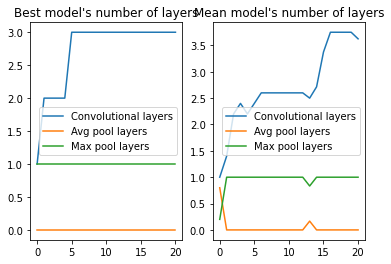

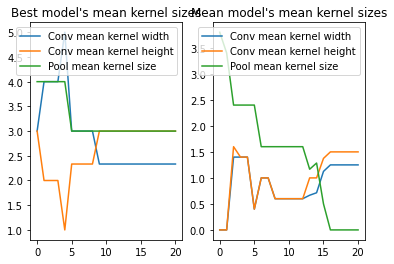

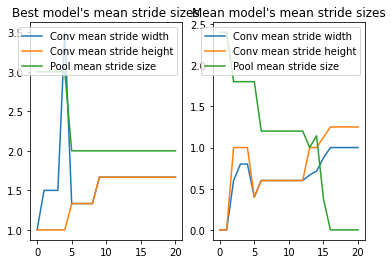

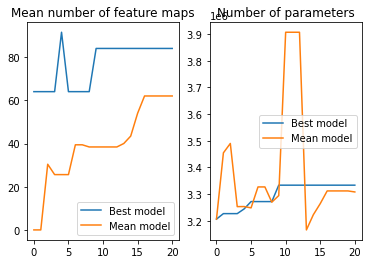


Iteration 21 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 bees entered scouting mode


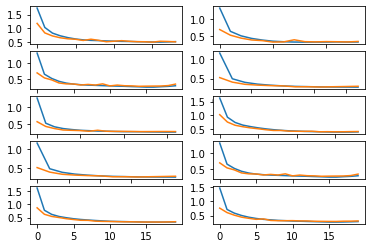

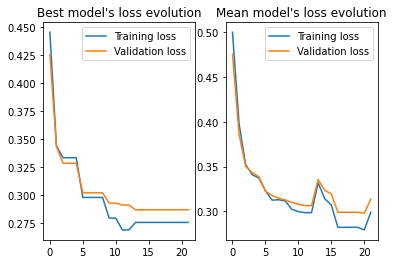

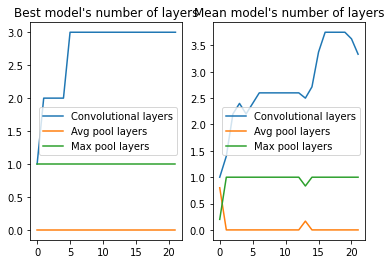

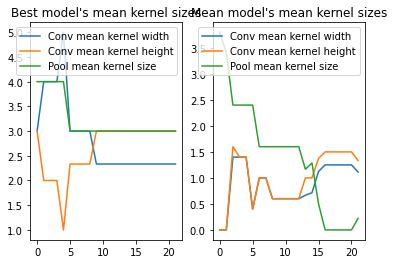

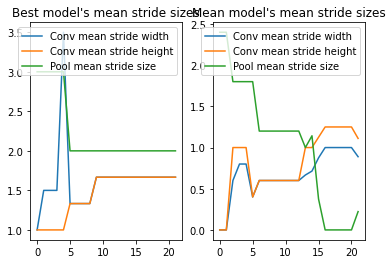

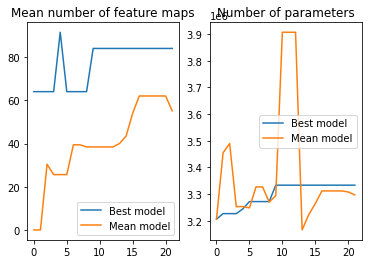


Iteration 22 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

3 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


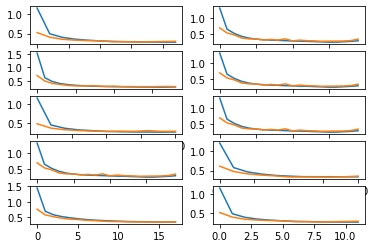

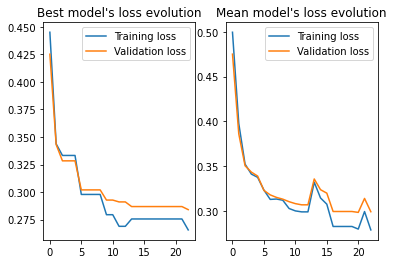

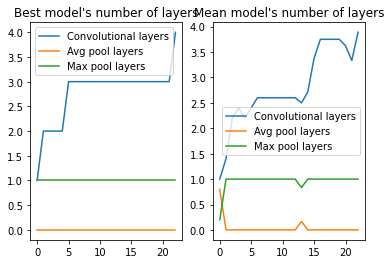

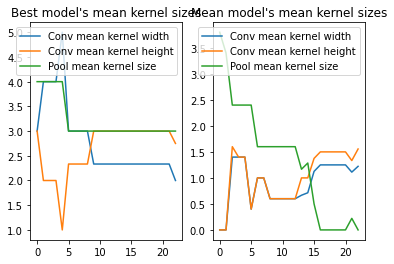

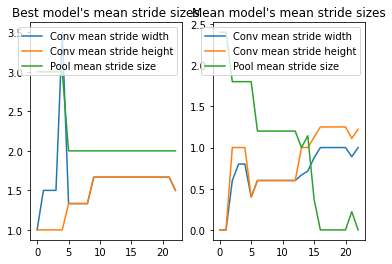

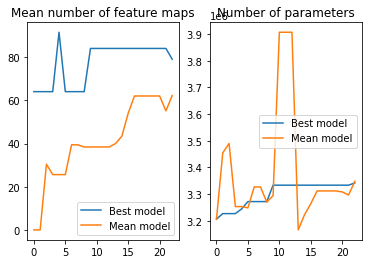


Iteration 23 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 bees entered scouting mode


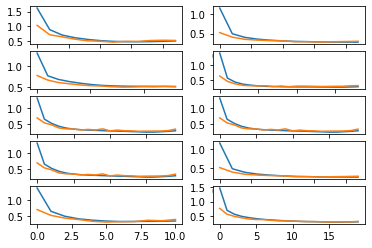

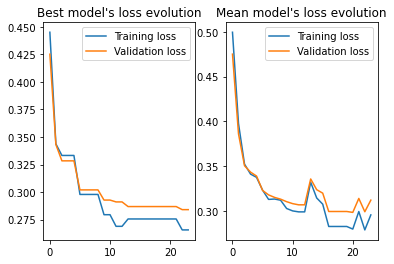

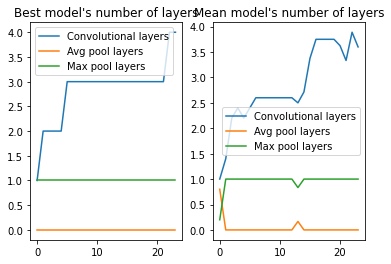

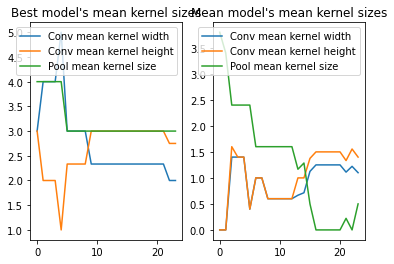

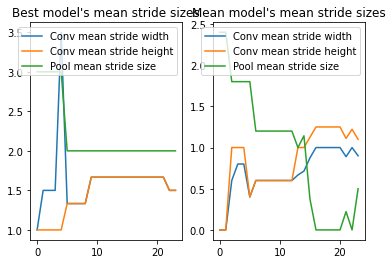

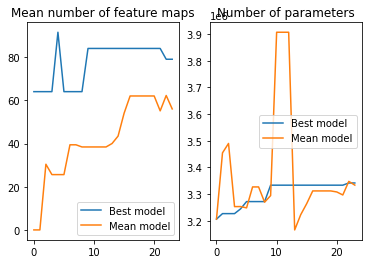


Iteration 24 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 bees entered scouting mode


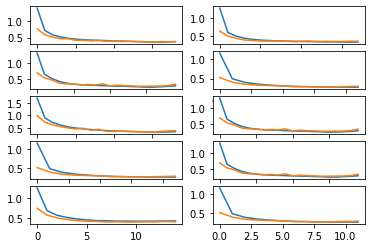

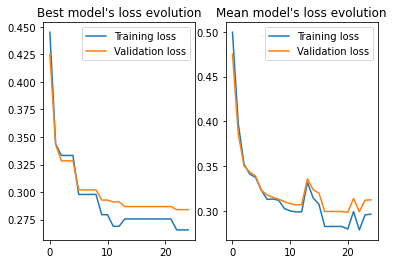

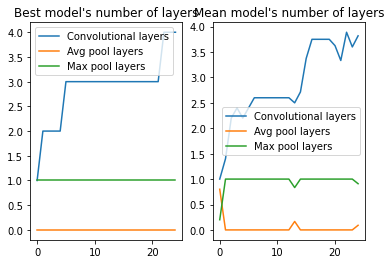

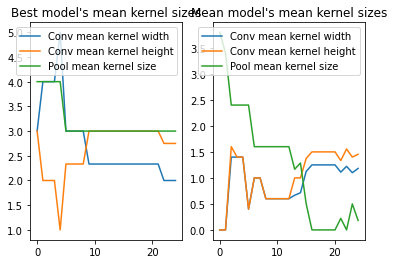

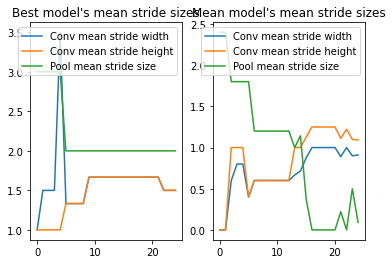

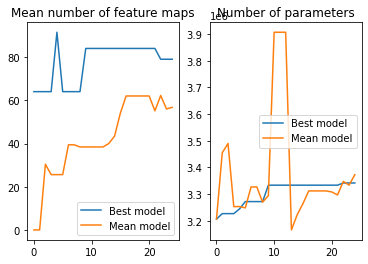


Iteration 25 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 bees entered scouting mode


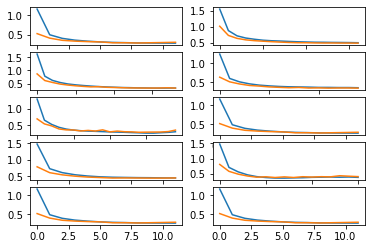

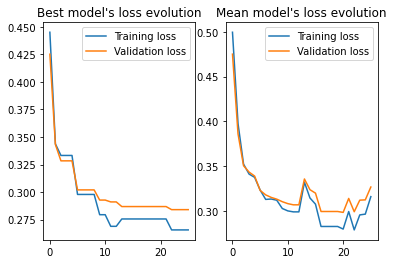

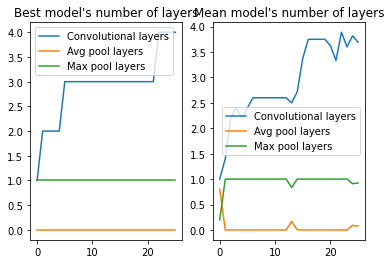

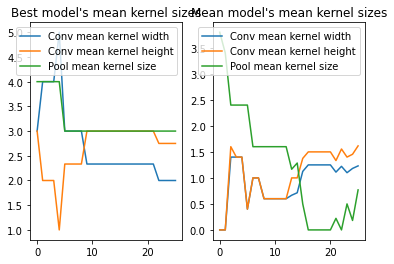

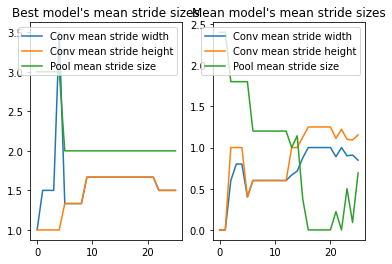

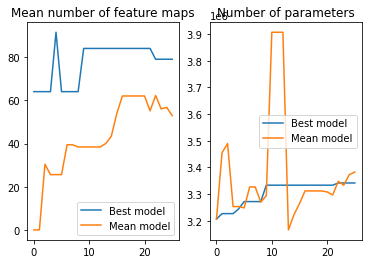


Iteration 26 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 bees entered scouting mode


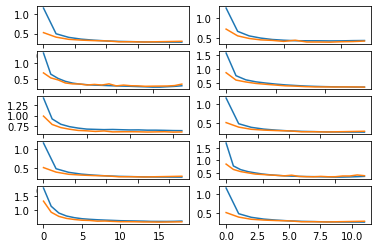

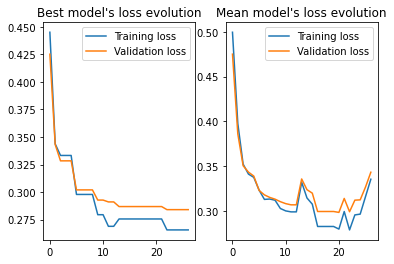

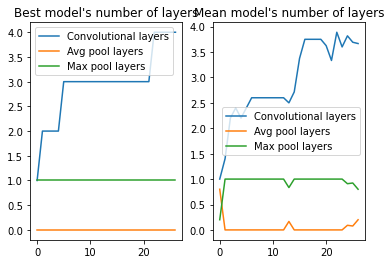

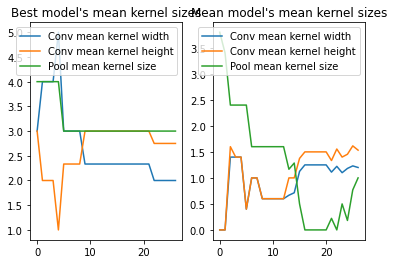

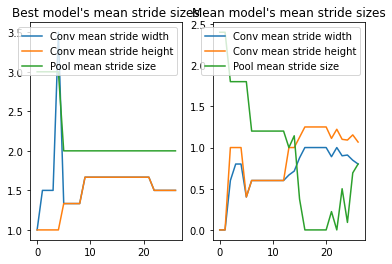

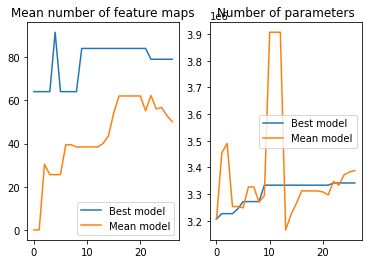


Iteration 27 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

3 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

3 bees entered scouting mode


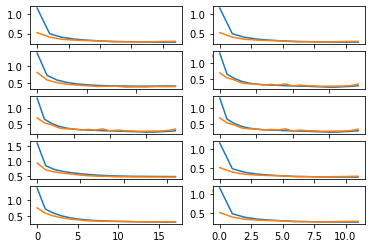

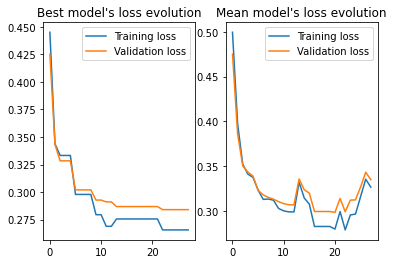

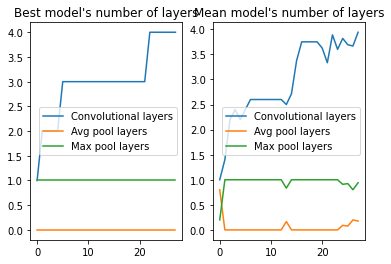

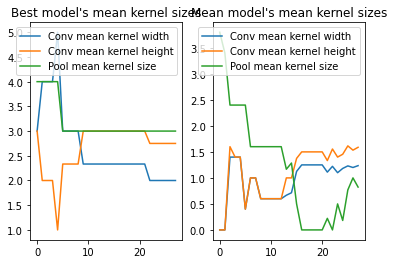

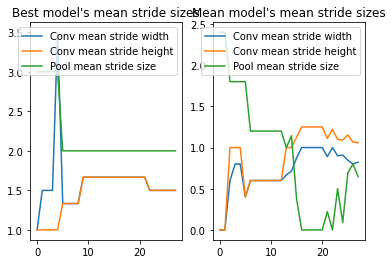

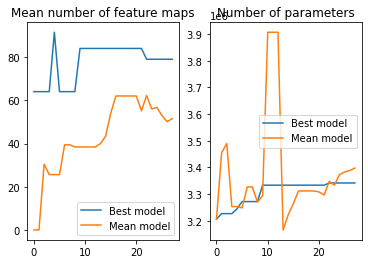


Iteration 28 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

3 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


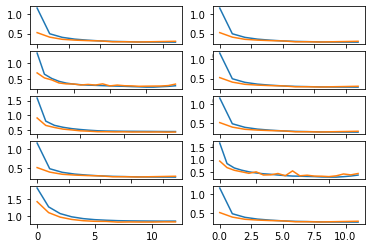

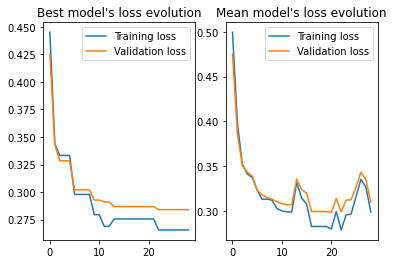

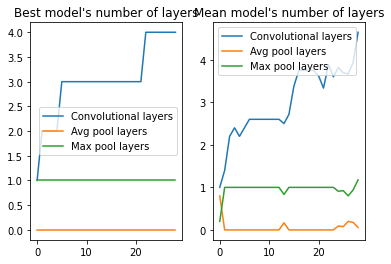

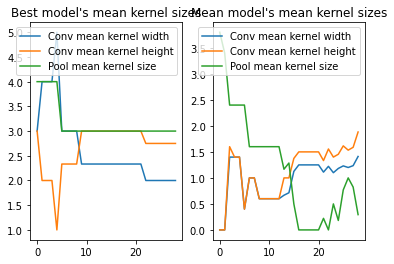

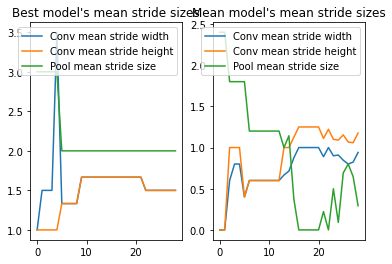

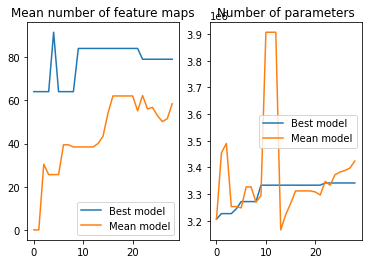


Iteration 29 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


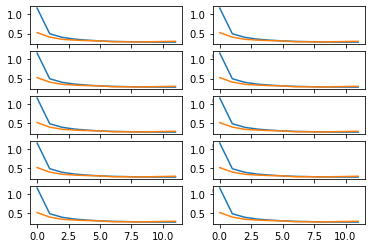

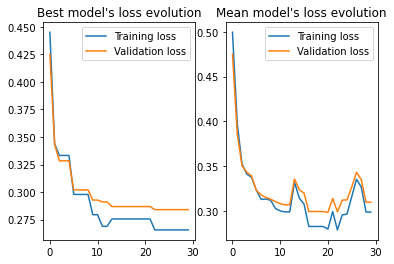

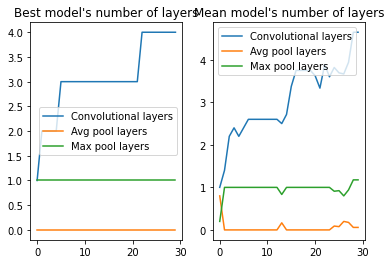

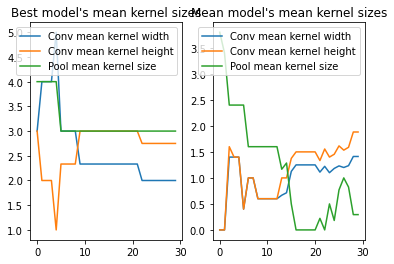

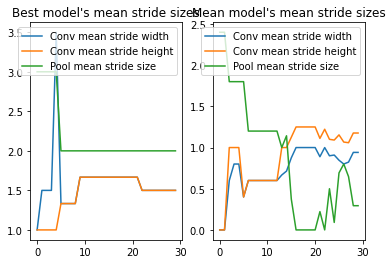

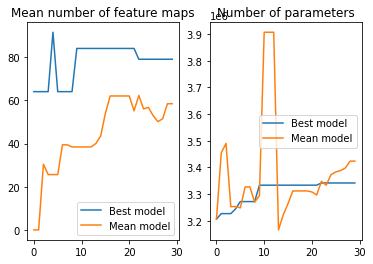


Iteration 30 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/704 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


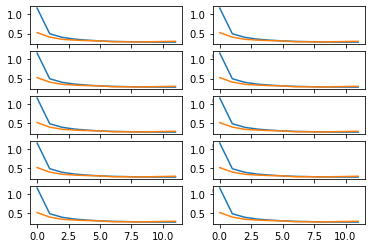

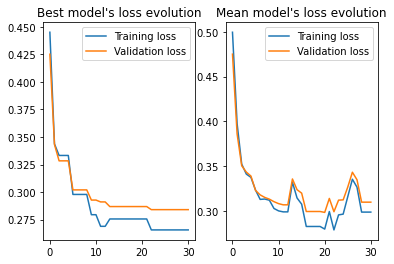

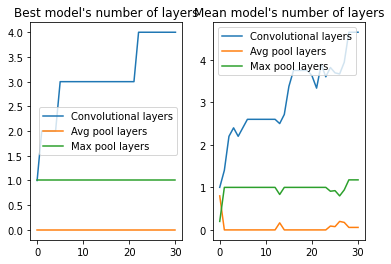

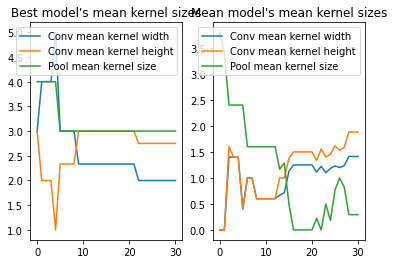

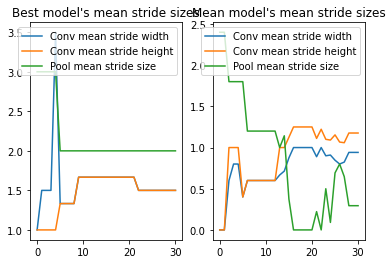

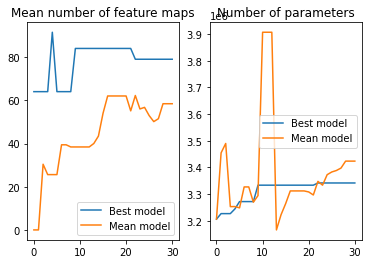

Algorithm unable to find suitable food source in 30 iterations.


In [42]:
#@title Main
from torchvision import datasets, transforms

criterion = nn.NLLLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

val_loader = copy.deepcopy(train_loader)  # Creates a copy of the object 

#We take the first 45k images for training
train_loader.dataset.data = train_loader.dataset.data[:45000,:,:]
train_loader.dataset.targets = train_loader.dataset.targets[:45000]

#And the rest for validation
val_loader.dataset.data = val_loader.dataset.data[45000:,:,:]
val_loader.dataset.targets = val_loader.dataset.targets[45000:]


# Fetch the test data as well
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

hive = Beehive(Np = 4, model_name = "[CIFAR10 test]", fs_exhaustion_limit = 15, cycle_length = 8, max_cycles = 8, lr_bounds = [5e-6, 5e-5])

hive.find_foodsource(perf_thresh = 0, max_iter = 32)

hive.save_models(folder = ".\\saved_models\\CIFAR10", directory = ".\\")

In [44]:
def validate(model, dataloader):
    loss = 0
    accuracy = 0
    model.eval()

    with tqdm(total=len(dataloader), leave = False, desc='Computing accuracy') as pbar:
        with torch.no_grad():
            for images,labels in dataloader:
                logprobs = model.forward(images)
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class.T == labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                pbar.update(1)
    model.train()
    return accuracy.detach().numpy()/len(dataloader)


In [45]:
model = torch.load(YOUR_MODEL_PATH)

print("Training accuracy for the best model:", validate(model, train_loader))
print("Validation accuracy for the best model:", validate(model, val_loader))
print("Test accuracy for the best model:", validate(model, test_loader))

Computing accuracy:   0%|          | 0/704 [00:00<?, ?it/s]

Training accuracy for the best model: 0.9143288352272727


Computing accuracy:   0%|          | 0/235 [00:00<?, ?it/s]

Validation accuracy for the best model: 0.9057402265832779


Computing accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Test accuracy for the best model: 0.9007762738853503
